# Projeto 02 - Sepsis Detection

### Introdução

A sepse ocorre quando substâncias químicas liberadas na corrente sanguínea para combater uma infecção desencadeiam uma inflamação em todo o corpo. Isso pode causar uma série de alterações que danificam diversos sistemas de órgãos, levando-os a falhar e, às vezes, resultando em morte.

https://www.einstein.br/doencas-sintomas/sepse-hemodinamica

### Objetivo
O grande problema com o diagnóstico preciso de sepse é que ele envolve a obtenção de amostras de sangue e urina do paciente, e até que sejam aferidas às quantidades relativas de lactato, leucócitos e proteína C reativa ou feita a cultura de urina, que são indicadores mais precisos de sepse, o paciente pode apresentar uma piora exponencial no seu quadro clínico.

Desta forma, o objetivo é elaborar um alarme “pré-séptico” utilizando aprendizado de máquina somente nos sinais vitais dos pacientes, assim, 
a equipe médica pode priorizar a coleta de sangue e urina destes pacientes.

### Base de Dados
A base para modelagem do alarme "pré-séptico" foi extraída do prontuário de diversos pacientes em 2019 que apresentaram sinais, ou não, de infecção generalizada. Todos os dados foram digitalizados manualmente por funcionários da administração do hospital. O diagnóstico final dos pacientes, para gerar o rótulo de sepse, foi obtido através da análise das medidas do lactato, leucócitos e proteína C reativa, além do casamento dessas medidas com o estado dos sinais vitais do paciente na situação.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
np.random.seed(2021)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Aprendizado de Máquina/training_data_sepse.csv')

# Conhecendo os dados


ID<br>
N° de Atendimento (N° do Paciente)<br>
Temperatura<br>
Pulso<br>
Respiração<br>
Pa_min (Pressão Mínima)<br>
Pa_max (Pressão Máxima)

In [ ]:
df_train.head()

,id,num_atend,temperatura,pulso,respiracao,pa_min,pa_max,sepse
0,1,6066066,36.0,117.0,NaN,113.0,72.0,1
1,2,6019916,36.0,105.0,NaN,NaN,NaN,1
2,3,6000000,38.0,118.0,NaN,110.0,70.0,1
3,4,5993343,37.0,136.0,NaN,NaN,NaN,1
4,5,6001799,37.0,104.0,NaN,NaN,NaN,1


Verificando presença de dados faltantes e duplicados

In [ ]:
nLinhas , nColunas = df_train.shape

dupl = df_train.duplicated().sum()/nLinhas

print('Porcentagem de linhas duplicadas:', round(dupl*100,2))

Porcentagem de linhas duplicadas: 70.31


Pode ocorrer de uma mesma pessoa ter seus sinais vitais coletados mais de uma vez e isso não caracteriza um erro de base, dado que é esperado que ocorra.

In [ ]:
#Verificado a quantidade de NaN por atributo
nan_train= pd.DataFrame()
nan_train['Qtd Nan'] = df_train.isna().sum()
nan_train['Qtd Nan %'] = round(100*df_train.isna().sum()/len(df_train),2)
nan_train.head(6)

Frequencia treino:


,Qtd Nan,Qtd Nan %
temperatura,2145,12.66
pulso,2736,16.14
respiracao,13734,81.03
pa_min,8466,49.95
pa_max,8468,49.96
sepse,0,0.00


In [ ]:
#Retirando variaveis que nao sao importantes para a modelagem
df_train.drop(['id', 'num_atend'], axis=1, inplace= True)


Verificando balanceamento da base

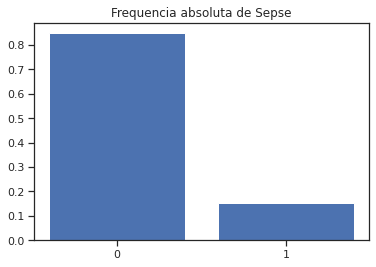

In [ ]:
y = df_train.sepse.value_counts()/df_train.sepse.value_counts().sum() #frequencia absoluta
plt.bar(['0','1'],y)
plt.title('Frequencia absoluta de Sepse')
plt.show()

Nota-se pelo gráfico acima que a variável alvo está desbalanceada. Um desbalanceamento da classe ocorre quando existe desproporção entre o número de exemplos de uma ou mais classes em relação ao restante.

Ao usar um modelo de classificação nos dados, o resultado do mesmo seria enviesado. Para evitar que isso ocorra, será utilizada a amostragem estratificada durante a modelagem.


# Pré-processamento

## Tratando o campo temperatura

In [ ]:
treino = df_train.copy()
teste = df_test.copy()

In [ ]:
treino.temperatura.unique()

array([  36. ,   38. ,   37. ,   35. ,   32. ,    nan,   39. ,   35.8,
          0. ,   34. ,   36.7,   35.6,  356. ,   40. ,  131. ,   36.8,
         35.1,   36.1,   35.4,   33.6,   37.6,   36.6,   35.5,   36.5,
       3602. ,   37.2,    6. ,  378. ,   36.9,  -35. ,   36.2,   36.3,
         37.7,   33. ,   85. ,  336. ,  368. ,   37.5,   35.3,   35.7,
         35.9,   36.4])

In [ ]:
teste.temperatura.unique()

array([ 36. ,  37. ,   nan,  39. ,  36.6,  38. ,  36.7,  35. ,  36.3,
        37.2,  34. ,  33. ,   0. ,  37.5,  35.8,  37.7,  36.8,  35.3,
        36.1,  35.4,  35.5,  36.5,  37.6,  36.2,  35.1,  35.6,  36.9,
       378. ,  36.4, -35. ,  40. ,  35.7,  35.9,  33.6])

Alguns valores como 336, 378, por exemplo, entende-se que foi algum erro na hora de passar os dados para a planilha. Logo, tais valores serão corrigidos.

In [ ]:
treino.temperatura.replace(378:37.8, 336:33.6, 368:36.8, 356:35.6}, inplace=True)
treino.temperatura.replace(3602, np.nan, inplace=True)

In [ ]:
treino.temperatura = treino.temperatura.apply(abs)
teste.temperatura = teste.temperatura.apply(abs)

Temperaturas nulas serão substituídas por NaN

In [ ]:
treino.temperatura.replace(0, np.nan, inplace=True)
teste.temperatura.replace(0, np.nan, inplace=True)